In [1]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz

# Amazon Meta Data

In [3]:
file_path = 'Data/amazon_meta.json'  
amazon_df = pd.read_json(file_path, lines=True, compression=None)

In [4]:
print(f"📦 Total products in the dataset: {len(amazon_df)}")

📦 Total products in the dataset: 633883


# Incidents Data

In [5]:
df_arts = pd.read_csv('Data/Toysandchildren_ArtsandCrafts.csv', skiprows=2)
df_riding = pd.read_csv('Data/Toysandchildren_Riding_Toys.csv', skiprows=1)
df_toys = pd.read_csv('Data/Toysandchildren_Toys.csv', skiprows=1)

In [6]:
recalls_df = pd.concat([df_arts, df_riding, df_toys], ignore_index=True)
# Preview
print("Combined recall records:", len(recalls_df))
print("Columns:", recalls_df.columns.tolist())
recalls_df.head(3)

Combined recall records: 2514
Columns: ['Report No.', 'Report Date', 'Sent to Manufacturer / Importer / Private Labeler', 'Publication Date', 'Category of Submitter', 'Product Description', 'Product Category', 'Product Sub Category', 'Product Type', 'Product Code', 'Manufacturer / Importer / Private Labeler Name', 'Brand', 'Model Name or Number', 'Serial Number', 'UPC', 'Date Manufactured', 'Manufacturer Date Code', 'Retailer', 'Retailer State', 'Purchase Date', 'Purchase Date Is Estimate', 'Incident Description', 'City', 'State', 'ZIP', 'Location', '(Primary) Victim Severity', "(Primary) Victim's Sex", 'My Relation To The (Primary) Victim', "(Primary) Victim's Age (years)", 'Submitter Has Product', 'Product Was Damaged Before Incident', 'Damage Description', 'Damage Repaired', 'Product Was Modified Before Incident', 'Have You Contacted The Manufacturer', 'If Not Do You Plan To', 'Answer Explanation', 'Company Comments', 'Associated Report Numbers']


,Report No.,Report Date,Sent to Manufacturer / Importer / Private Labeler,Publication Date,Category of Submitter,Product Description,Product Category,Product Sub Category,Product Type,Product Code,...,Submitter Has Product,Product Was Damaged Before Incident,Damage Description,Damage Repaired,Product Was Modified Before Incident,Have You Contacted The Manufacturer,If Not Do You Plan To,Answer Explanation,Company Comments,Associated Report Numbers
0,20231002-D13C7-2147344911,10/2/2023,10/27/2023,11/20/2023,Consumer,Slime globe with colored spheres which resembl...,Toys & Children,Arts & Crafts,Molding Compounds (1376),1376,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOYSMITH: Thank you for the opportunity to rev...,NaN
1,20180126-BBF18-2147393362,1/26/2018,4/13/2018,4/27/2018,Consumer,Slime kit from Nickelodeon by Cra-Z-Art,Toys & Children,Arts & Crafts,Molding Compounds (1376),1376,...,Yes,No,NaN,NaN,No,Yes,NaN,I already have explained.,We at Cra-Z-Art® are very sorry that the cons...,NaN
2,20141231-7C153-2147437145,12/31/2014,1/9/2015,1/26/2015,Consumer,Lalaloopsy Color Me Doll ( Squiggles N. Shapes...,Toys & Children,Arts & Crafts,Crayons or Chalk (5010),5010,...,NaN,NaN,NaN,NaN,NaN,No,No,NaN,The chalk markers included with this item are ...,NaN


# Three Different Methods to Find Amazon Data Labels:

### Method 1: Restrict Matching by Brand First, Then Match by Title

In this method, products are first filtered based on brand similarity. Only those that pass the brand threshold are then compared by title to determine a final matc.


In [7]:
def match_amazon_by_brand(
    amazon_df: pd.DataFrame,
    recalls_df: pd.DataFrame,
    score_threshold: int = 90
) -> dict[str, tuple[pd.DataFrame, pd.DataFrame, list[int]]]:
    """
    For each unique brand in recalls_df, find all amazon_df rows whose
    'brand' fuzzy-matches at or above score_threshold.
    Returns a dict mapping recall_brand -> (recall_rows_df, matching_amazon_rows_df, global_recall_indices).
    """
    amazon = amazon_df.copy()
    recalls = recalls_df.copy()

    amazon['brand'] = amazon['brand'].astype(str).str.lower().str.strip()
    recalls['Brand'] = recalls['Brand'].astype(str).str.lower().str.strip()

    matched = {}

    for recall_brand in recalls['Brand'].dropna().unique():
        mask = amazon['brand'].apply(
            lambda x: fuzz.token_sort_ratio(x, recall_brand) >= score_threshold
        )
        amazon_matches = amazon[mask]
        recall_rows = recalls[recalls['Brand'] == recall_brand]

        if not amazon_matches.empty:
            # ✅ capture the *original recall indices*
            global_indices = recall_rows.index.tolist()
            matched[recall_brand] = (recall_rows.copy(), amazon_matches.copy(), global_indices)

    print(f"✅ Found matches for {len(matched)} recall-brand entries.")
    return matched


def tag_amazon_by_description(
    amazon_df: pd.DataFrame,
    matched_by_brand: dict[str, tuple[pd.DataFrame, pd.DataFrame, list[int]]],
    desc_score_threshold: int = 80
) -> pd.DataFrame:
    """
    Tag each amazon row with:
    - 'Is match' = 1 if title matches any recall description
    - 'matched_recall_indices' = list of original recalls_df indices
    """
    amazon = amazon_df.copy()
    amazon['Is match'] = 0
    amazon['matched_recall_indices'] = [[] for _ in range(len(amazon))]

    for recall_brand, (recall_rows, amazon_matches, global_recall_indices) in matched_by_brand.items():
        recall_descs = recall_rows['Product Description'].astype(str).fillna("").str.lower().str.strip()
        amazon_titles = amazon_matches['title'].astype(str).fillna("").str.lower().str.strip()

        for local_recall_i, recall_desc in enumerate(recall_descs):
            global_recall_i = global_recall_indices[local_recall_i]  # map local to global index
            for amazon_i, title in amazon_titles.items():
                if fuzz.token_set_ratio(recall_desc, title) >= desc_score_threshold:
                    amazon.at[amazon_i, 'Is match'] = 1
                    amazon.at[amazon_i, 'matched_recall_indices'].append(global_recall_i)

    total = amazon['Is match'].sum()
    print(f"Total matched Amazon listings: {total}")
    print("Match counts:", amazon['Is match'].value_counts().to_dict())
    return amazon

In the first method, results are stored in the `amazon_df` dataframe using two columns: **`Is match`** and **`matched_recall_indices`**.  
- The **`Is match`** column contains `1` if a match is found, and `0` otherwise.  
- The **`matched_recall_indices`** column contains the indices of the matched recall entries when a match exist.


In [8]:
matched_by_brand = match_amazon_by_brand(amazon_df, recalls_df, score_threshold = 90)
amazon_df = tag_amazon_by_description(amazon_df, matched_by_brand, desc_score_threshold = 80)

✅ Found matches for 586 recall-brand entries.
Total matched Amazon listings: 2153
Match counts: {0: 631730, 1: 2153}


### Method 2: Use `cdist` and Matrix Representation to Identify Matches

This method uses the `cdist` function to compute similarity scores between items, storing the results in a matrix. Matches are then identified based on threshold values applied to this similarity matrix.

In [15]:
from rapidfuzz import fuzz
from rapidfuzz.process import cdist

def compute_brand_similarity_matrix(recalls_df, amazon_df, scorer=fuzz.token_sort_ratio, score_cutoff=90, workers=24):
    """
    Compute a brand similarity matrix using fuzzy matching.
    Returns:
        similarity_brand_matrix: list of lists with (matched_string, score, amazon_index)
    """
    UNMATCHABLE = "__MISSING__"

    brand_queries = (recalls_df['Brand'].fillna(UNMATCHABLE).astype(str).str.lower().str.strip().tolist())
    
    brand_choices = (amazon_df['brand'].fillna(UNMATCHABLE).astype(str).str.lower().str.strip().tolist())

    similarity_brand_matrix = cdist(brand_queries, brand_choices, scorer=scorer, processor=None, score_cutoff=score_cutoff, workers=workers)
    
    return similarity_brand_matrix

def compute_description_similarity_matrix(recalls_df, amazon_df, scorer=fuzz.token_set_ratio, score_cutoff=80, workers=24):
    """
    Compute a description/title similarity matrix using fuzzy matching.
    Returns:
        similarity_desc_matrix: list of lists with (matched_string, score, amazon_index)
    """
    desc_queries = (recalls_df['Product Description'].fillna("").astype(str).str.lower().str.strip().tolist())
    
    title_choices = (amazon_df['title'].fillna("").astype(str).str.lower().str.strip().tolist())

    similarity_desc_matrix = cdist(desc_queries, title_choices, scorer=scorer, processor=None, score_cutoff=score_cutoff, workers=workers)

    return similarity_desc_matrix

#### Scorer fuzz.token_set_ratio, score cutoff 90 for brand, 80 for Product Description

In [17]:
brand_matrix_s2_sc90 = compute_brand_similarity_matrix(recalls_df, amazon_df, scorer=fuzz.token_set_ratio, score_cutoff=90, workers=24)
desc_matrix_s2_sc80 = compute_description_similarity_matrix(recalls_df, amazon_df,  scorer=fuzz.token_set_ratio, score_cutoff=80, workers=24)

In [18]:
import numpy as np
import pandas as pd
from collections import defaultdict

def compute_amazon_match_df(amazon_df, recalls_df, brand_matrix, desc_matrix):
    """
    For each amazon_df row, collect the list of recall_df indices that matched
    both brand and description, and flag whether there was at least one match.

    Args:
        amazon_df:    Amazon metadata DataFrame (index aligns with matrix cols).
        recalls_df:   Recall DataFrame used to build the matrices (index aligns with matrix rows).
        brand_matrix: Output of cdist(...) for brands (sparse or dense).
        desc_matrix:  Output of cdist(...) for descriptions (sparse or dense).

    Returns:
        pd.DataFrame with two columns, indexed like amazon_df:
          - matched_recall_indices: list of recall_df indices matching both brand & desc
          - is_match:               1 if list non-empty, else 0
    """
    # 1) map amazon_idx -> list of recall_df indices
    matches = defaultdict(list)
    recall_global_indices = list(recalls_df.index)
    n_reports = len(brand_matrix)

    # guard: if recalls_df shorter, truncate
    if len(recall_global_indices) < n_reports:
        recall_global_indices = recall_global_indices[:n_reports]

    for report_pos in range(n_reports):
        # extract the sets of matching amazon indices
        row_b = brand_matrix[report_pos]
        if isinstance(row_b, np.ndarray):
            brand_idxs = set(np.nonzero(row_b)[0])
        else:
            brand_idxs = {idx for _, _, idx in row_b}

        row_d = desc_matrix[report_pos]
        if isinstance(row_d, np.ndarray):
            desc_idxs = set(np.nonzero(row_d)[0])
        else:
            desc_idxs = {idx for _, _, idx in row_d}

        common = brand_idxs & desc_idxs
        if not common:
            continue

        recall_idx = recall_global_indices[report_pos]
        for amazon_idx in common:
            matches[amazon_idx].append(recall_idx)

    # 2) build the two columns
    matched_lists = pd.Series(
        [matches.get(i, []) for i in amazon_df.index],
        index=amazon_df.index,
        name='matched_recall_indices'
    )
    is_match = matched_lists.str.len().gt(0).astype(int)

    # 3) return as DataFrame
    return pd.DataFrame({
        'matched_recall_indices': matched_lists,
        'is_match':                is_match
    })

In [19]:
match_df_s2_sc90 =  compute_amazon_match_df(amazon_df, recalls_df, brand_matrix_s2_sc90, desc_matrix_s2_sc80)

The `compute_amazon_match_df` function returns a dataframe with two columns: **`Is match`** and **`matched_recall_indices`**.  
- **`Is match`** contains a label (`1` if there is a match, `0` otherwise).  
- **`matched_recall_indices`** contains the list of recall indices corresponding to the matches for each row.

In [23]:
match_df_s2_sc90['is_match'].value_counts()

is_match
0    628778
1      5105
Name: count, dtype: int64

This method results in 5,105 matches.


### Method 3: Similar to Method 2 with Different Scorer and Thresholds

This method follows the same steps as Method 2, but uses a different similarity scorer and cutoff values:
- **Scorer:** `fuzz.ratio`
- **Brand similarity threshold:** 80
- **Product Description similarity threshold:** 70

In [25]:
brand_matrix_s1_sc80 = compute_brand_similarity_matrix(recalls_df, amazon_df, scorer=fuzz.ratio, score_cutoff=80, workers=24)
desc_matrix_s1_sc70 = compute_description_similarity_matrix(recalls_df, amazon_df,  scorer=fuzz.ratio, score_cutoff=70, workers=24)

match_df_s1_sc70 =  compute_amazon_match_df(amazon_df, recalls_df, brand_matrix_s1_sc80, desc_matrix_s1_sc70)

In [29]:
match_df_s1_sc70['is_match'].value_counts()

is_match
0    633005
1       878
Name: count, dtype: int64

This method results in 878 matches.

## Find The Number of Amazon Products Matched to Each Recall

In [31]:
from typing import List

def build_recall_match_df(matched_recall_indices, recall_df):
    """
    Given a Series mapping each Amazon index to a list of recall_df indices
    (matched_recall_indices), produce a DataFrame of length recall_df with:
      - matched_amazon_indices: list of Amazon indices matching that recall
      - number_of_matches:      count of those matches
    """
    # Prepare empty lists for each recall index
    recall_index = recall_df.index
    matched_lists = {idx: [] for idx in recall_index}

    # Invert the mapping: for each amazon_idx, for each recall_idx in its list,
    # append amazon_idx to the recall's matched_amazon_indices
    for amazon_idx, recall_list in matched_recall_indices.items():
        if not isinstance(recall_list, list):
            continue
        for recall_idx in recall_list:
            if recall_idx in matched_lists:
                matched_lists[recall_idx].append(amazon_idx)

    # Build the output DataFrame
    out_df = pd.DataFrame({
        'matched_amazon_indices': [matched_lists[idx] for idx in recall_index],
    }, index=recall_index)
    out_df['number_of_matches'] = out_df['matched_amazon_indices'].apply(len)

    return out_df

#### 1. Recall Matches for Method 1

In [33]:
recall_matches1 = build_recall_match_df(amazon_df['matched_recall_indices'], recalls_df)

In [35]:
recall_matches1['number_of_matches'].sort_values(ascending=False)

1442    204
9       146
621     115
2052    101
873      76
       ... 
913       0
912       0
911       0
910       0
2513      0
Name: number_of_matches, Length: 2514, dtype: int64

Some products in the recall list are matched by multiple Amazon products.  
The highest number of Amazon products matched to a single recall item is **204**


In [37]:
match_summary = (
    recall_matches1['number_of_matches']
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={'number_of_matches': 'number_of_matches'})
)
match_summary.head(20)

,number_of_matches,count
0,0,2129
1,1,121
2,2,70
3,3,44
4,4,33
5,5,19
6,6,15
7,7,14
8,8,5
9,9,6


A total of **2,129** products from the recall list did **not** match any Amazon product.  
This means that only **385** recall items (2,514 - 2,129) were matched to at least one Amazon product



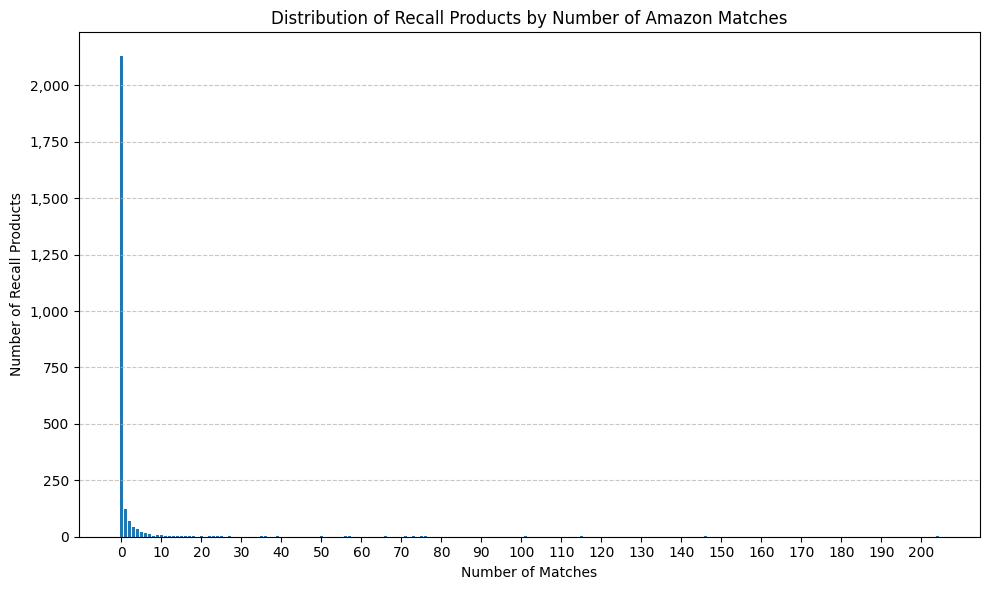

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

match_counts = recall_matches1['number_of_matches'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(match_counts.index, match_counts.values)
plt.xlabel('Number of Matches')
plt.ylabel('Number of Recall Products')
plt.title('Distribution of Recall Products by Number of Amazon Matches')

# Format Y-axis with thousands separator
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Set X-ticks every 10
plt.xticks(ticks=range(min(match_counts.index), max(match_counts.index)+1, 10))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Let's print out the product that matched 204 products.

In [41]:
def print_metadata(df, indices):
    
    for i in indices:
        if i >= len(df):
            print(f"⚠️ Index {i} is out of bounds.")
            continue

        meta_row = df.iloc[i]
        
        print("🔹 META")
        print(f"Brand:   {meta_row.get('brand', 'N/A')}")
        print(f"Title:   {meta_row.get('title', 'N/A')}")
        print(f"Feature: {meta_row.get('feature', 'N/A')}")
        print("-" * 80)

def print_recall_data(df, indices):
    
    for i in indices:
        if i >= len(df):
            print(f"⚠️ Index {i} is out of bounds.")
            continue

        recall_row = df.iloc[i]

        print("🔹 REPORT")
        print(f"Brand:               {recall_row.get('Brand', 'N/A')}")
        print(f"Product Description: {recall_row.get('Product Description', 'N/A')}")
        print("-" * 80)

In [43]:
indices = recall_matches1.loc[recall_matches1['number_of_matches']==204,'matched_amazon_indices']

In [45]:
indices

1442    [1755, 1758, 1773, 1907, 55477, 67279, 72799, ...
Name: matched_amazon_indices, dtype: object

In [53]:
recall_index = 1442
recall_indices = [recall_index]
amazon_indices = indices[recall_index]
print_recall_data(recalls_df, recall_indices)
print_metadata(amazon_df, amazon_indices[:10])

🔹 REPORT
Brand:               Syma
Product Description: R/C Helicopter 
--------------------------------------------------------------------------------
🔹 META
Brand:   SYMA
Title:   Syma 3 Channel S107/S107G Mini Indoor Co-Axial R/C Helicopter w/ Gyro (White Color)
Feature: []
--------------------------------------------------------------------------------
🔹 META
Brand:   SYMA
Title:   SYMA S009G AH-64 Apache 3 Channel Indoor Helicopter with Gyroscope
Feature: ['S0099G AH-64 Apache 3 channel helicopter indoor']
--------------------------------------------------------------------------------
🔹 META
Brand:   SYMA
Title:   Syma 3 Channel S107/S107G Mini Indoor Co-Axial R/C Helicopter w/ Gyro (Green Color)
Feature: ["2 Selectable Frequencies Let's You Fly Up To 2 Helicopters At Once", 'Full 3 channels: up, down, left, right, forward, and backward', 'The transmitter has an alignment trim, a charging and power indicator, a left/right lever and trimmer', 'Suitable for indoor flying only', "F

We observe that Syma branded R/C Helicopter got 204 matches in the Amazon Product list. 

#### 2. Recall Matches for Method 2

In [55]:
# Recall Matches for Method 2
recall_matches_s2_sc90 = build_recall_match_df(match_df_s2_sc90['matched_recall_indices'], recalls_df)

In [57]:
recall_matches_s2_sc90['number_of_matches'].sort_values(ascending=False)

1697    2361
1442     208
9        148
621      130
2052     101
        ... 
948        0
946        0
945        0
944        0
2513       0
Name: number_of_matches, Length: 2514, dtype: int64

One recall item is matched to **2,361** Amazon products. Let's print the matched items.


In [72]:
recall_matches_s2_sc90.loc[1697]

matched_amazon_indices    [2021, 2027, 2028, 2031, 2111, 2140, 3253, 333...
number_of_matches                                                      2361
Name: 1697, dtype: object

In [59]:
indices2 = recall_matches_s2_sc90.loc[recall_matches_s2_sc90['number_of_matches']==2361,'matched_amazon_indices']

In [61]:
indices2

1697    [2021, 2027, 2028, 2031, 2111, 2140, 3253, 333...
Name: matched_amazon_indices, dtype: object

In [65]:
recall_index = 1697
recall_indices = [recall_index]
amazon_indices = indices2[recall_index]
print_recall_data(recalls_df, recall_indices)
print_metadata(amazon_df, amazon_indices[:15])

🔹 REPORT
Brand:               Barbie doll by Mattel
Product Description: Barbie doll
--------------------------------------------------------------------------------
🔹 META
Brand:   Barbie
Title:   Barbie Teresa Butterfly Art Doll (1998)
Feature: ['1998 - Mattel - Friends Of Barbie Series', 'Butterfly Art Teresa Dol - 12 Inches Tall', 'Includes: Brush / 2 Sheets of Decorations / Knit Bikini / Jeans Skirt', 'Out of Prodcution - Item #20361', 'New - Mint - Limited Edition - Collectible']
--------------------------------------------------------------------------------
🔹 META
Brand:   Barbie
Title:   Barbie Butterfly Art Christie Doll (1998)
Feature: ['Butterfly Art Christie Doll is a 1998 Mattel production made in Indonesia & US.', 'INCLUDES: AA Ethnic Christie Doll is approx. 11.5" tall & has long Dark Brown Hair & Brown Eyes. Christie Doll wears a Skirt, 2 Pce Swimsuit, and comes w Temporary Transfers (TATTOOS), Hair Brush & Instructions.', 'Box is from Canada & has Multi-Lingual Writin

We observe that the recall product matched to **2,361** Amazon products is a **Barbie doll by Mattel**.  
The printed data above shows that there are many Barbie doll by Mattel products in the Amazon dataset. However, when we inspect the full list, we find that several **Barbie baby dolls** are included in this match — even though they may not perfectly correspond to the recalled item.

But first, let's check whether **Method 1** captured this match.

In [68]:
recall_matches1.loc[1697]

matched_amazon_indices    []
number_of_matches          0
Name: 1697, dtype: object

We observe that **Method 1** did not capture this recall item, whereas **Method 2** matched it to **2,361** Amazon products.  
This accounts for a significant portion of the **2,952**-match difference between the two methods.

When we examine the Amazon indices matched by Method 2 to the **Barbie doll by Mattel**, we find that all **56** of these items were instead matched to a **different recall product** in Method 1.

In [74]:
number_of_matches = 0
for ind_a in amazon_indices:
    if amazon_df.loc[ind_a,'Is match']==1:
        number_of_matches+=1
        recall_indices = amazon_df.loc[ind_a,'matched_recall_indices']
        if number_of_matches<15:   # Limit number of printed data
            print_recall_data(recalls_df, recall_indices)
            print_metadata(amazon_df, [ind_a])
print(f"Number of matches:{number_of_matches}")

🔹 REPORT
Brand:               Barbie
Product Description: Hula Hair Barbie
--------------------------------------------------------------------------------
🔹 META
Brand:   Barbie
Title:   Barbie Jam'n Glam TERESA DOLL With HAIR EXTENSIONS by Mattel
Feature: ["Barbie JAM 'n GLAM TERESA DOLL is a 2000 Mattel production. Box has MULTI-Lingual Writing.", 'INCLUDES: TERESA DOLL approx. 11.5" tall w 2 Tone TWIST HAIR (Brown & PINK) & Flexible EVER-FLEX WAIST. Teresa Doll wears a Blue Faux FUR JACKET, a Glittery Pink TOP, a Pair of Silvery CAPRIS, a Pair of Pink w Silvery SHOES, & Comes w Head Microphone, Pair of SUN GLASSES, 3 x HAIR EXTENSIONS (Blue, Green & Purple), & Pretend CD\'s.', "Jam'n Glam Teresa Doll is GREAT for your Collection, for Personal Use - Fun Play, Display, Diorama, or Whatever YOU Prefer.", 'For Ages 3+ Years. All colors, sizes & description details are provided to the best of my ability & may not be exact & may vary.', '*NEW & SEALED. Box has minor wear. For BOX CONDITI

We observe that **56** of the products in the list of **2,361** Amazon matches (linked by Method 2 to the **Barbie doll by Mattel**) were also matched to **Hula Hair Barbie** by Method 1.  
This suggests that there are multiple **Barbie dolls** included in the recall list.

Although certain details—such as hair color or other attributes—may not always perfectly align, we will **retain these matches** in our labeling process.  
We believe that **false positives are preferable to false negatives** — it is more important to capture all potentially hazardous or customer-dissatisfying products, even at the risk of some imperfect matches.

#### 3. Recall Matches for Method 3

In [76]:
# Recall Matches for Method 3
recall_matches_s1_sc70 = build_recall_match_df(match_df_s1_sc70['matched_recall_indices'], recalls_df)

In [78]:
recall_matches_s1_sc70['number_of_matches'].sort_values(ascending=False)

151     100
274      67
753      51
1416     41
153      35
       ... 
866       0
867       0
868       0
869       0
2513      0
Name: number_of_matches, Length: 2514, dtype: int64

## Comparison of Results of Different Methods

In [80]:
from typing import Dict, List

def compare_match_columns(col_a, col_b):
    """
    Compare two binary (0/1) pd.Series and return index lists for
    their intersection and differences.

    Returns a dict with keys:
      - 'intersection'
      - 'only_a'
      - 'only_b'
      - 'symmetric_diff'
    """
    # align indices, filling missing with 0
    a, b = col_a.align(col_b, join='inner', fill_value=0)
    a_mask = a == 1
    b_mask = b == 1

    intersection   = a.index[a_mask & b_mask].tolist()
    only_a         = a.index[a_mask & ~b_mask].tolist()
    only_b         = a.index[~a_mask & b_mask].tolist()
    symmetric_diff = a.index[a_mask ^ b_mask].tolist()

    return {
        'intersection':    intersection,
        'only_a':          only_a,
        'only_b':          only_b,
        'symmetric_diff':  symmetric_diff
    }

## Compare Method 1 with Method 2

In [82]:
result12 = compare_match_columns(amazon_df['Is match'],match_df_s2_sc90['is_match'])

print("✓ Both methods agree on:", len(result12['intersection']))
print("✗ Only method1:",      len(result12['only_a']))
print("✗ Only method2:",      len(result12['only_b']))
print("🔀 Methods disagree:",          len(result12['symmetric_diff']))

✓ Both methods agree on: 2150
✗ Only method1: 3
✗ Only method2: 2955
🔀 Methods disagree: 2958


In [84]:
def print_difference(diff_amazon_ind, match_df, amazon_df):
    for id_a in diff_amazon_ind:
        print(f"Amazon Index: {id_a}")
        print_metadata(amazon_df, [id_a])
        recall_indices = match_df.loc[id_a,['matched_recall_indices']]
        print_recall_data(recalls_df, recall_indices.iloc[0])

#### 3 matches catched by Method 1 and not catched by Method2:

In [86]:
print_difference(result12['only_a'], amazon_df, amazon_df)

Amazon Index: 109146
🔹 META
Brand:   
Title:   2&quot; Lumistick Mini Glow Stick Light Sticks Mixed Colors (100 pcs.)
Feature: []
--------------------------------------------------------------------------------
🔹 REPORT
Brand:                
Product Description: 7 Glow Stick
--------------------------------------------------------------------------------
Amazon Index: 171171
🔹 META
Brand:   
Title:   &quot;Snap &amp; Glow&quot; Super Bright Glow Stick Bracelets (Pack of 50) (Assorted)
Feature: ['<span class="a-text-bold">ASIN:\n                    </span>\n                    <span>B0042FQRZG</span>', '', '<span class="a-text-bold">Date first listed on Amazon:\n                    </span>\n                    <span>January 15, 2016</span>', '<span class="a-text-bold">\n                    Average Customer Review:\n                </span>\n                \n\n\n\n\n<style type="text/css">\n    /* \n    * Fix for UDP-1061. Average customer reviews has a small extra line on hover \n    *

#### Matches catched by Method 2 and not catched by Method 1:

We already checked the indices matching Barbie Doll by Mattel above. Here we will eliminate those rows:

In [90]:
Barbie_Doll_Indices = indices2[1697]

In [92]:
diff12_other = [x for x in result12['only_b'] if x not in Barbie_Doll_Indices]
print_difference(diff12_other[:20], match_df_s2_sc90, amazon_df)

Amazon Index: 7
🔹 META
Brand:   UDI
Title:   UDI U806 Infrared Remote Control Helicopter W/gyro - RED
Feature: ['Includes 3.7 volt lithium battery', 'Includes USB data cable']
--------------------------------------------------------------------------------
🔹 REPORT
Brand:               UDI R/C U16
Product Description: Remote Control Helicopter
--------------------------------------------------------------------------------
Amazon Index: 1942
🔹 META
Brand:   UDI
Title:   3.5 Channel U810 Fighter RC Gyro Control Helicopter w/ Launching Missiles
Feature: ['Directions: Up/Down, Forward/Backward, Right/left turn, and Hovering', 'Functions: Left/right missile launch, Acceleration, Missile launch with Sound', 'Control Distance: 10m +', 'Charging Time: 45 minutes', 'Charging methods: USB and transmitter']
--------------------------------------------------------------------------------
🔹 REPORT
Brand:               UDI R/C U16
Product Description: Remote Control Helicopter
---------------------

The first 20 matched items look good.  
Now, we will randomly print the matches that were **captured by Method 2 but not by Method 1**.

In [98]:
import random
diff12_other = [x for x in result12['only_b'] if x not in Barbie_Doll_Indices]
# 2) Pick k distinct random elements:
k = 20
random_subset = random.sample(diff12_other, k)
print_difference(random_subset, match_df_s2_sc90, amazon_df)

Amazon Index: 100070
🔹 META
Brand:   Dragon
Title:    Dragon 1
Feature: ['Scale: 1/35', 'Ages: 5+', 'Dragon P/N: 6325']
--------------------------------------------------------------------------------
🔹 REPORT
Brand:               sensory Snuggables Plush Stuffed Animal - dragon
Product Description: [REDACTED]From TargetBy Make Believe Ideas LtdSensory Snuggables Plush Stuffed Animal - DragonHighlights    Sensory Snuggables baby range    Green dragon plush toy    Nose squeaker to squeeze and grip    Chime rattle to delight and engage    Ribbon tags to tug and feel    Surprise crinkles to stimulate hearing    Tough teether to soothe sore gums    Mixed textures to touch and exploreDescriptionExplore the adorable Sensory Snuggables Dragon to stimulate and engage your little one’s senses. Wiggle the dragon to hear the noisy chime rattle, trace little fingers over the surprise, rustling crinkles, then practice squeezing and gripping the nose to hear it squeak! There is a tough teether to he

These matches aren't perfect, there are some false positives, but there are a lot of correct matches as well.  
Therefore, we will assign a label of **1** to all items matched by **Method 2**


## Compare Method 1 with Method 3

In [101]:
result13 = compare_match_columns(amazon_df['Is match'],match_df_s1_sc70['is_match'])

print("✓ Both methods agree on:", len(result13['intersection']))
print("✗ Only method1:",      len(result13['only_a']))
print("✗ Only method3:",      len(result13['only_b']))
print("🔀 Methods disagree:",          len(result12['symmetric_diff']))

✓ Both methods agree on: 385
✗ Only method1: 1768
✗ Only method3: 493
🔀 Methods disagree: 2958


## Compare Method 2 with Method 3

In [103]:
result23 = compare_match_columns(match_df_s2_sc90['is_match'],match_df_s1_sc70['is_match'])

print("✓ Both methods agree on:", len(result23['intersection']))
print("✗ Only method2:",      len(result23['only_a']))
print("✗ Only method3:",      len(result23['only_b']))
print("🔀 Methods disagree:",          len(result23['symmetric_diff']))

✓ Both methods agree on: 395
✗ Only method2: 4710
✗ Only method3: 483
🔀 Methods disagree: 5193


There are **483** Amazon products that were matched by **Method 3**, but not matched by **Method 2**.

In [113]:
# 2) Pick k distinct random elements:
k = 10
random_subset2 = random.sample(result23['only_b'], k)
print_difference(random_subset2, match_df_s1_sc70, amazon_df)

Amazon Index: 54132
🔹 META
Brand:   Fisher-Price
Title:   Fisher-Price Shake 'N Go Dog
Feature: ['Each barnyard racing animal is featured in a creative vehicle that is activated', 'When kids shake the toys to reverse them up and then watch them go', 'Hound dog shake and go racer', 'For ages 2 to 5 years']
--------------------------------------------------------------------------------
🔹 REPORT
Brand:               Fisher Price
Product Description: Fisher price soothe and glow
--------------------------------------------------------------------------------
Amazon Index: 189416
🔹 META
Brand:   Fisher-Price
Title:   Fisher-Price Laugh &amp; Learn ABC Train
Feature: ['Laugh and Learn ABC Train helps babies learn their ABCs', 'Two modes of play: Learning and Music', 'Has three different ways for baby to light up the digital display and activate music and SFX', 'Bat at the roller ball to activate two songs, including the ABC song', 'Press the smokestack to go through the alphabet letter by l

It appears that this set contains many **false positives**.  
Therefore, we will not include it to our labeled dataset.

In [117]:
s2 = match_df_s2_sc90['is_match'].astype(bool)
base = amazon_df['Is match'].astype(bool)

# Create 'is_match_final' = 1 if any of the three is True, else 0
amazon_df['is_match_final'] = (s2 | base).astype(int)

In [119]:
amazon_df['is_match_final'].value_counts()

is_match_final
0    628775
1      5108
Name: count, dtype: int64

In [121]:
amazon_df.columns

Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'main_cat', 'similar_item',
       'date', 'price', 'asin', 'imageURL', 'imageURLHighRes', 'details',
       'Is match', 'matched_recall_indices', 'is_match_final'],
      dtype='object')

In [129]:
is_match_final = amazon_df[['asin','is_match_final']].copy()
is_match_final.to_csv("is_match_final.csv", index=True) 

In [131]:
amazon_df_final = amazon_df.drop(columns=['Is match', 'matched_recall_indices']).copy()
amazon_df_final.to_csv("amazon_df_final.csv", index=True, escapechar='\\')

## Additional Recall Matches: